# Classification

## 1. Setting

### 1.1. Environment

In [1]:
import numpy as np
import os, matplotlib, random, math, shutil
from matplotlib import pyplot as plt
import skimage
from tqdm import tqdm
from skimage import io as skio
from skimage import transform as skit

import tensorflow as tf
from tensorflow import keras as tfk

print(tf.__version__)

2023-12-14 22:56:17.989112: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-14 22:56:18.772327: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-12-14 22:56:18.772423: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-12-14 22:56:18.772430: W tensorfl

2.11.0


In [10]:
# os.environ["CUDA_VISIBLE_DEVICES"] = '0,1,2,3'
# Tensorflow/Keras GPU check
import tensorflow as tf
print("현재 tensorflow 버전은 무엇인가? : %s" %(tf.__version__))
device_list = tf.config.list_physical_devices('GPU')
print("사용 가능한 GPU가 존재하는가? (True or False): ", bool(device_list))
if device_list:
    print("현재 사용 가능한 GPU의 수는 {}개 입니다.".format(len(device_list)))
    print("GPU 목록은 아래와 같습니다.")
    for device in device_list:
        print(device)
else:
    print("사용 가능한 GPU가 존재하지 않습니다. 혹은 GPU를 Tensorflow가 찾지 못하고 있습니다.")

현재 tensorflow 버전은 무엇인가? : 2.12.0
사용 가능한 GPU가 존재하는가? (True or False):  True
현재 사용 가능한 GPU의 수는 4개 입니다.
GPU 목록은 아래와 같습니다.
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')


### 1.2. Module

In [2]:
# 신경망 모델
def CNN(model_name, input_size, class_num, drop_rate):
  # input = tfk.layers.Input(input_size)
  if model_name == 'vgg16':
    conv_base = tfk.applications.VGG16(input_shape=input_size, classes=class_num, include_top=False, pooling='avg', weights=None)
  else:
    print('!ERROR! please insert correct model name! (vgg16, vgg19, resnet50)')
  input = conv_base.input
  output = tfk.layers.Dense(class_num, activation='softmax')(conv_base.output)
  cnn = tfk.Model(input, output)
  return cnn

In [3]:
model_name = 'vgg16' # 신경망 모델 이름: vgg16, vgg19, resnet50
input_size = (128, 128, 3) # 입력 영상 크기: (32,32,3), (64, 64, 3), (128, 128, 3), (256, 256, 3)
class_num = 2 # 분류할 클래스 수
train_num = 200 # 클래스 당 Train number
val_num = 50 # 클래스 당 validation number
batch_size = 4 # Batch Size: 4, 8, 16
train_epoch = 20
drop_rate = 0.5 # drop_out

## 2. Dataset

### 2.1. Data Loading

In [17]:
# 폴더 확인
data_path = '/home/student/Datasets/jhjeong/VUNO/fruit_veg/'
print('데이터셋 폴더 내부 확인(train/test) = ', os.listdir(data_path))
train_data_path = os.path.join(data_path, 'train')
test_data_path = os.path.join(data_path, 'test')
print('학습 데이터셋 폴더 내부 확인 = ', os.listdir(train_data_path))
print('테스트 데이터셋 폴더 내부 확인 = ', os.listdir(test_data_path))

데이터셋 폴더 내부 확인(train/test) =  ['test', 'train']
학습 데이터셋 폴더 내부 확인 =  ['fruits', 'vegetables']
테스트 데이터셋 폴더 내부 확인 =  ['fruits', 'vegetables']


In [18]:
# 클래스 확인
label_list = sorted(os.listdir(train_data_path))
print(label_list)

['fruits', 'vegetables']


In [19]:
train_paths, val_paths = [], []
for k in sorted(os.listdir(train_data_path)):
  fol_path = os.path.join(train_data_path, k)
  num = 0
  for i in sorted(os.listdir(fol_path)):
    file_path = os.path.join(fol_path, i)
    if num < val_num:
      val_paths.append(file_path)
    else:
      train_paths.append(file_path)
    num += 1
print('학습 데이터셋(Train) 숫자 = ', len(train_paths))
print('검증 데이터셋(Validation) 숫자 = ', len(val_paths))

학습 데이터셋(Train) 숫자 =  600
검증 데이터셋(Validation) 숫자 =  100


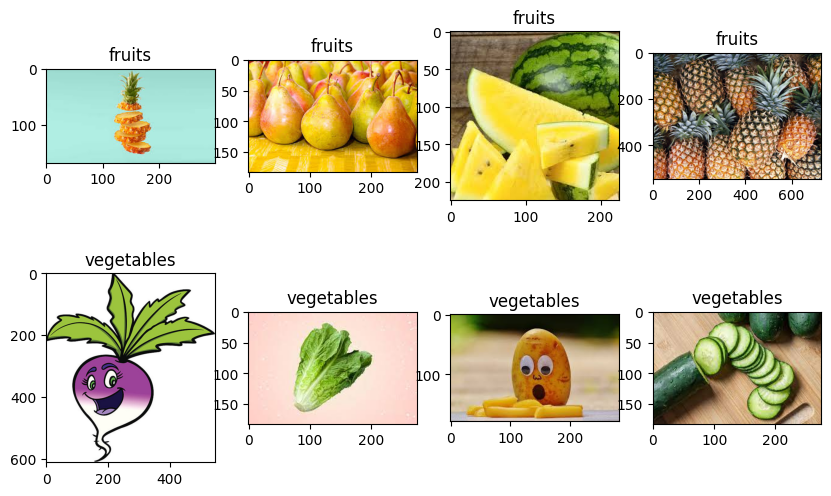

In [14]:
# 데이터 확인
fn, vn = 0, 0
plt.figure(figsize=(10, 6))
for i, i_ in enumerate(val_paths):
  sam_label = i_.split('/')[-2]
  if sam_label == 'fruits':
    fn += 1
  else:
    vn += 1
  if fn <= 4:
    sam_array = skio.imread(i_)
    plt.subplot(2,4,fn)
    plt.title(sam_label)
    plt.imshow(sam_array)
  elif vn <= 4:
    sam_array = skio.imread(i_)
    plt.subplot(2,4,vn+4)
    plt.title(sam_label)
    plt.imshow(sam_array)
  else:
    pass


### 2.2. Data Pre-processing

In [20]:
# Train dataset 전처리
train_x, train_y = [], []
pbar = tqdm(total=len(train_paths))
for i, i_ in enumerate(train_paths):
  image = skio.imread(i_)
  image = skit.resize(image, input_size)
  label = [0]*len(label_list)
  label[label_list.index(i_.split('/')[-2])] = 1
  train_x.append(image)
  train_y.append(label)
  pbar.set_description(f'Train processing --- ({i+1}/{len(train_paths)})')
  pbar.update(1)
pbar.close()
train_x = np.array(train_x)
train_y = np.array(train_y)
print('\nTrain 데이터 형태 = ', train_x.shape)
print('Train 정답지 형태 = ', train_y.shape)

Train processing --- (310/600):  52%|█████▏    | 310/600 [04:18<12:15,  2.54s/it]

RuntimeError: Exception thrown in SimpleITK ImageFileReader_Execute: /tmp/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:105:
sitk::ERROR: Unable to determine ImageIO reader for "/home/student/Datasets/jhjeong/VUNO/fruit_veg/train/vegetables/Image_22.png"